# I. Access Data in Google Drive

In [118]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [119]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Data_Science_in_Health_Care/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Data_Science_in_Health_Care


# II. Libraries

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set("poster")
import re
import altair as alt
import numpy as np
from numpy import unique, where
import math
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# III.Get Data

In [121]:
df_chapter_drug_sales = pd.read_csv("./data_mod/patients_and_drug_sales_by_practice_per_demographics_and_chapters.csv")
df_chapter_drug_sales.columns

Index(['PRACTICE', 'Female', 'Male', '00-04', '05-14', '15-24', '25-34',
       '35-44', '45-54', '55-64', '65-74', '75+', 'Female 00-04',
       'Female 05-14', 'Female 15-24', 'Female 25-34', 'Female 35-44',
       'Female 45-54', 'Female 55-64', 'Female 65-74', 'Female 75+',
       'Male 00-04', 'Male 05-14', 'Male 15-24', 'Male 25-34', 'Male 35-44',
       'Male 45-54', 'Male 55-64', 'Male 65-74', 'Male 75+', 'ITEMS', 'NIC',
       'NIC_1', 'NIC_2', 'NIC_3', 'NIC_4', 'NIC_5', 'NIC_6', 'NIC_7', 'NIC_8',
       'NIC_9', 'NIC_10', 'NIC_11', 'NIC_12', 'NIC_13', 'NIC_14', 'NIC_15',
       'NIC_18', 'NIC_19', 'NIC_20', 'NIC_21', 'NIC_22', 'NIC_23', 'ITEMS_1',
       'ITEMS_2', 'ITEMS_3', 'ITEMS_4', 'ITEMS_5', 'ITEMS_6', 'ITEMS_7',
       'ITEMS_8', 'ITEMS_9', 'ITEMS_10', 'ITEMS_11', 'ITEMS_12', 'ITEMS_13',
       'ITEMS_14', 'ITEMS_15', 'ITEMS_18', 'ITEMS_19', 'ITEMS_20', 'ITEMS_21',
       'ITEMS_22', 'ITEMS_23'],
      dtype='object')

In [122]:
print(df_chapter_drug_sales)

     PRACTICE    Female      Male  ...  ITEMS_21  ITEMS_22  ITEMS_23
0      A81001  0.506673  0.493327  ...  0.018863  0.001374  0.003623
1      A81002  0.507403  0.492597  ...  0.018490  0.001060  0.004681
2      A81004  0.483163  0.516837  ...  0.021659  0.001188  0.005455
3      A81005  0.515166  0.484834  ...  0.021275  0.001683  0.005589
4      A81006  0.503553  0.496447  ...  0.020249  0.000865  0.003773
...       ...       ...       ...  ...       ...       ...       ...
6796   Y05788  0.120192  0.879808  ...  0.015581  0.000000  0.000000
6797   Y05826  0.470529  0.529471  ...  0.049698  0.002367  0.003944
6798   Y06007  0.527949  0.472051  ...  0.024150  0.000757  0.003029
6799   Y06095  0.500000  0.500000  ...  0.000000  0.000000  0.000000
6800   Y06113  0.639687  0.360313  ...  0.074850  0.000000  0.071856

[6801 rows x 74 columns]


In [123]:
df_section_drug_sales = pd.read_csv("./data_mod/patients_and_drug_sales_by_practice_per_demographics_and_sections.csv")
df_section_drug_sales.columns

Index(['PRACTICE', 'Female', 'Male', '00-04', '05-14', '15-24', '25-34',
       '35-44', '45-54', '55-64',
       ...
       'ITEMS_2355', 'ITEMS_2360', 'ITEMS_2370', 'ITEMS_2375', 'ITEMS_2380',
       'ITEMS_2385', 'ITEMS_2390', 'ITEMS_2392', 'ITEMS_2394', 'ITEMS_2396'],
      dtype='object', length=424)

In [124]:
print(df_section_drug_sales)

     PRACTICE    Female      Male  ...  ITEMS_2392  ITEMS_2394  ITEMS_2396
0      A81001  0.506673  0.493327  ...     0.00000    0.000000    0.000000
1      A81002  0.507403  0.492597  ...     0.00000    0.000207    0.000284
2      A81004  0.483163  0.516837  ...     0.00000    0.000270    0.000162
3      A81005  0.515166  0.484834  ...     0.00006    0.000240    0.000240
4      A81006  0.503553  0.496447  ...     0.00000    0.000069    0.000138
...       ...       ...       ...  ...         ...         ...         ...
6796   Y05788  0.120192  0.879808  ...     0.00000    0.000000    0.000000
6797   Y05826  0.470529  0.529471  ...     0.00000    0.000000    0.000000
6798   Y06007  0.527949  0.472051  ...     0.00000    0.000505    0.000084
6799   Y06095  0.500000  0.500000  ...     0.00000    0.000000    0.000000
6800   Y06113  0.639687  0.360313  ...     0.00000    0.000000    0.000000

[6801 rows x 424 columns]


In [125]:
df_bnf_names = pd.read_csv("./data/20200311_1583928188440_BNF_Code_Information.csv")
bnf_chapter_dict = {}
for index, value in df_bnf_names[["BNF Chapter Code", "BNF Chapter"]].drop_duplicates().iterrows():
  bnf_chapter_dict.update({value["BNF Chapter Code"]: value["BNF Chapter"]})

bnf_section_dict = {}
for index, value in df_bnf_names[["BNF Section Code", "BNF Section"]].drop_duplicates().iterrows():
  bnf_section_dict.update({value["BNF Section Code"]: value["BNF Section"]})

print(df_bnf_names.columns)

Index(['BNF Chapter', 'BNF Chapter Code', 'BNF Section', 'BNF Section Code',
       'BNF Paragraph', 'BNF Paragraph Code', 'BNF Subparagraph',
       'BNF Subparagraph Code', 'BNF Chemical Substance',
       'BNF Chemical Substance Code', 'BNF Product', 'BNF Product Code',
       'BNF Presentation', 'BNF Presentation Code'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
print(df_bnf_names)

                    BNF Chapter  ...  BNF Presentation Code
0      Gastro-Intestinal System  ...        010101000BBABA0
1      Gastro-Intestinal System  ...        010101000BBADA0
2      Gastro-Intestinal System  ...        010101000BBAEA0
3      Gastro-Intestinal System  ...        010101000BBAFA0
4      Gastro-Intestinal System  ...        010101000BBAIA0
...                         ...  ...                    ...
81650          Stoma Appliances  ...            23985859803
81651          Stoma Appliances  ...            23985859804
81652          Stoma Appliances  ...            23985859805
81653          Stoma Appliances  ...            23985859806
81654          Stoma Appliances  ...            23990001111

[81655 rows x 14 columns]


# 1. How is the chapter distribution of ...

## ... NIC (Net ingredient cost - pounds and pence)

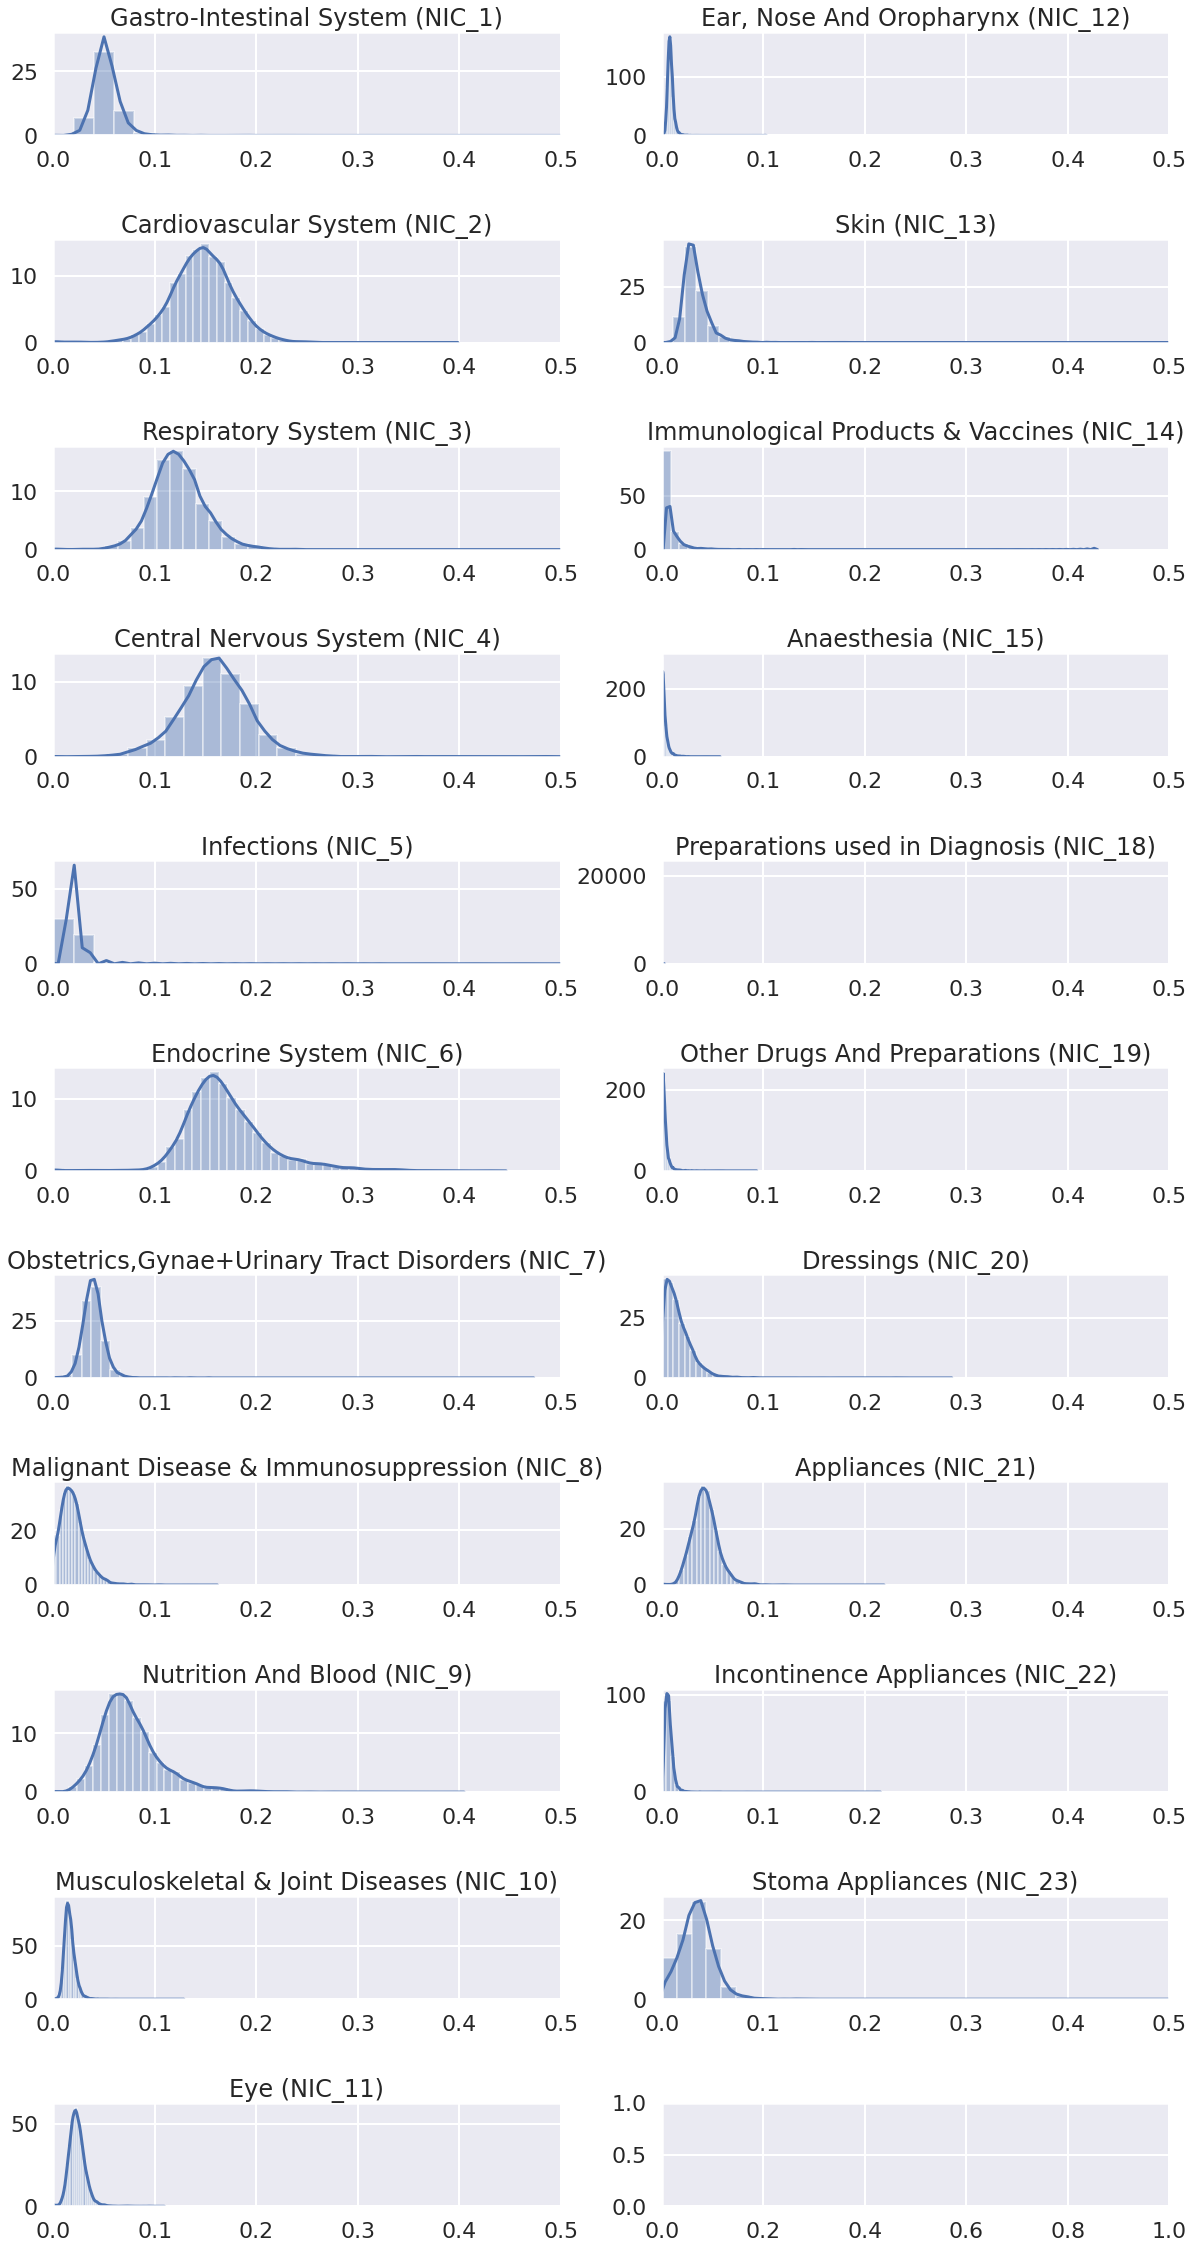

In [127]:
variables =['NIC_1', 'NIC_2', 'NIC_3', 'NIC_4', 'NIC_5', 'NIC_6', 'NIC_7', 'NIC_8',
       'NIC_9', 'NIC_10', 'NIC_11', 'NIC_12', 'NIC_13', 'NIC_14', 'NIC_15',
       'NIC_18', 'NIC_19', 'NIC_20', 'NIC_21', 'NIC_22', 'NIC_23']
n_columns = 2

n_rows = math.ceil(len(variables)/n_columns)
fig, axes = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(20,40))
plt.subplots_adjust(hspace=1)

for i in range(len(variables)):
    var = variables[i]
    title = bnf_chapter_dict[int(var.split('_')[1])] # Get ID from NIC and look it up in dict
    sns.distplot(df_chapter_drug_sales[var],
                 ax=axes[i%n_rows][i//n_rows])
    axes[i%n_rows][i//n_rows].set_xlim(0, 0.5)
    axes[i%n_rows][i//n_rows].set_title(f"{title} ({var})")
    axes[i%n_rows][i//n_rows].set_xlabel("")

## ... ITEMS (Prescription items dispensed - whole numbers)

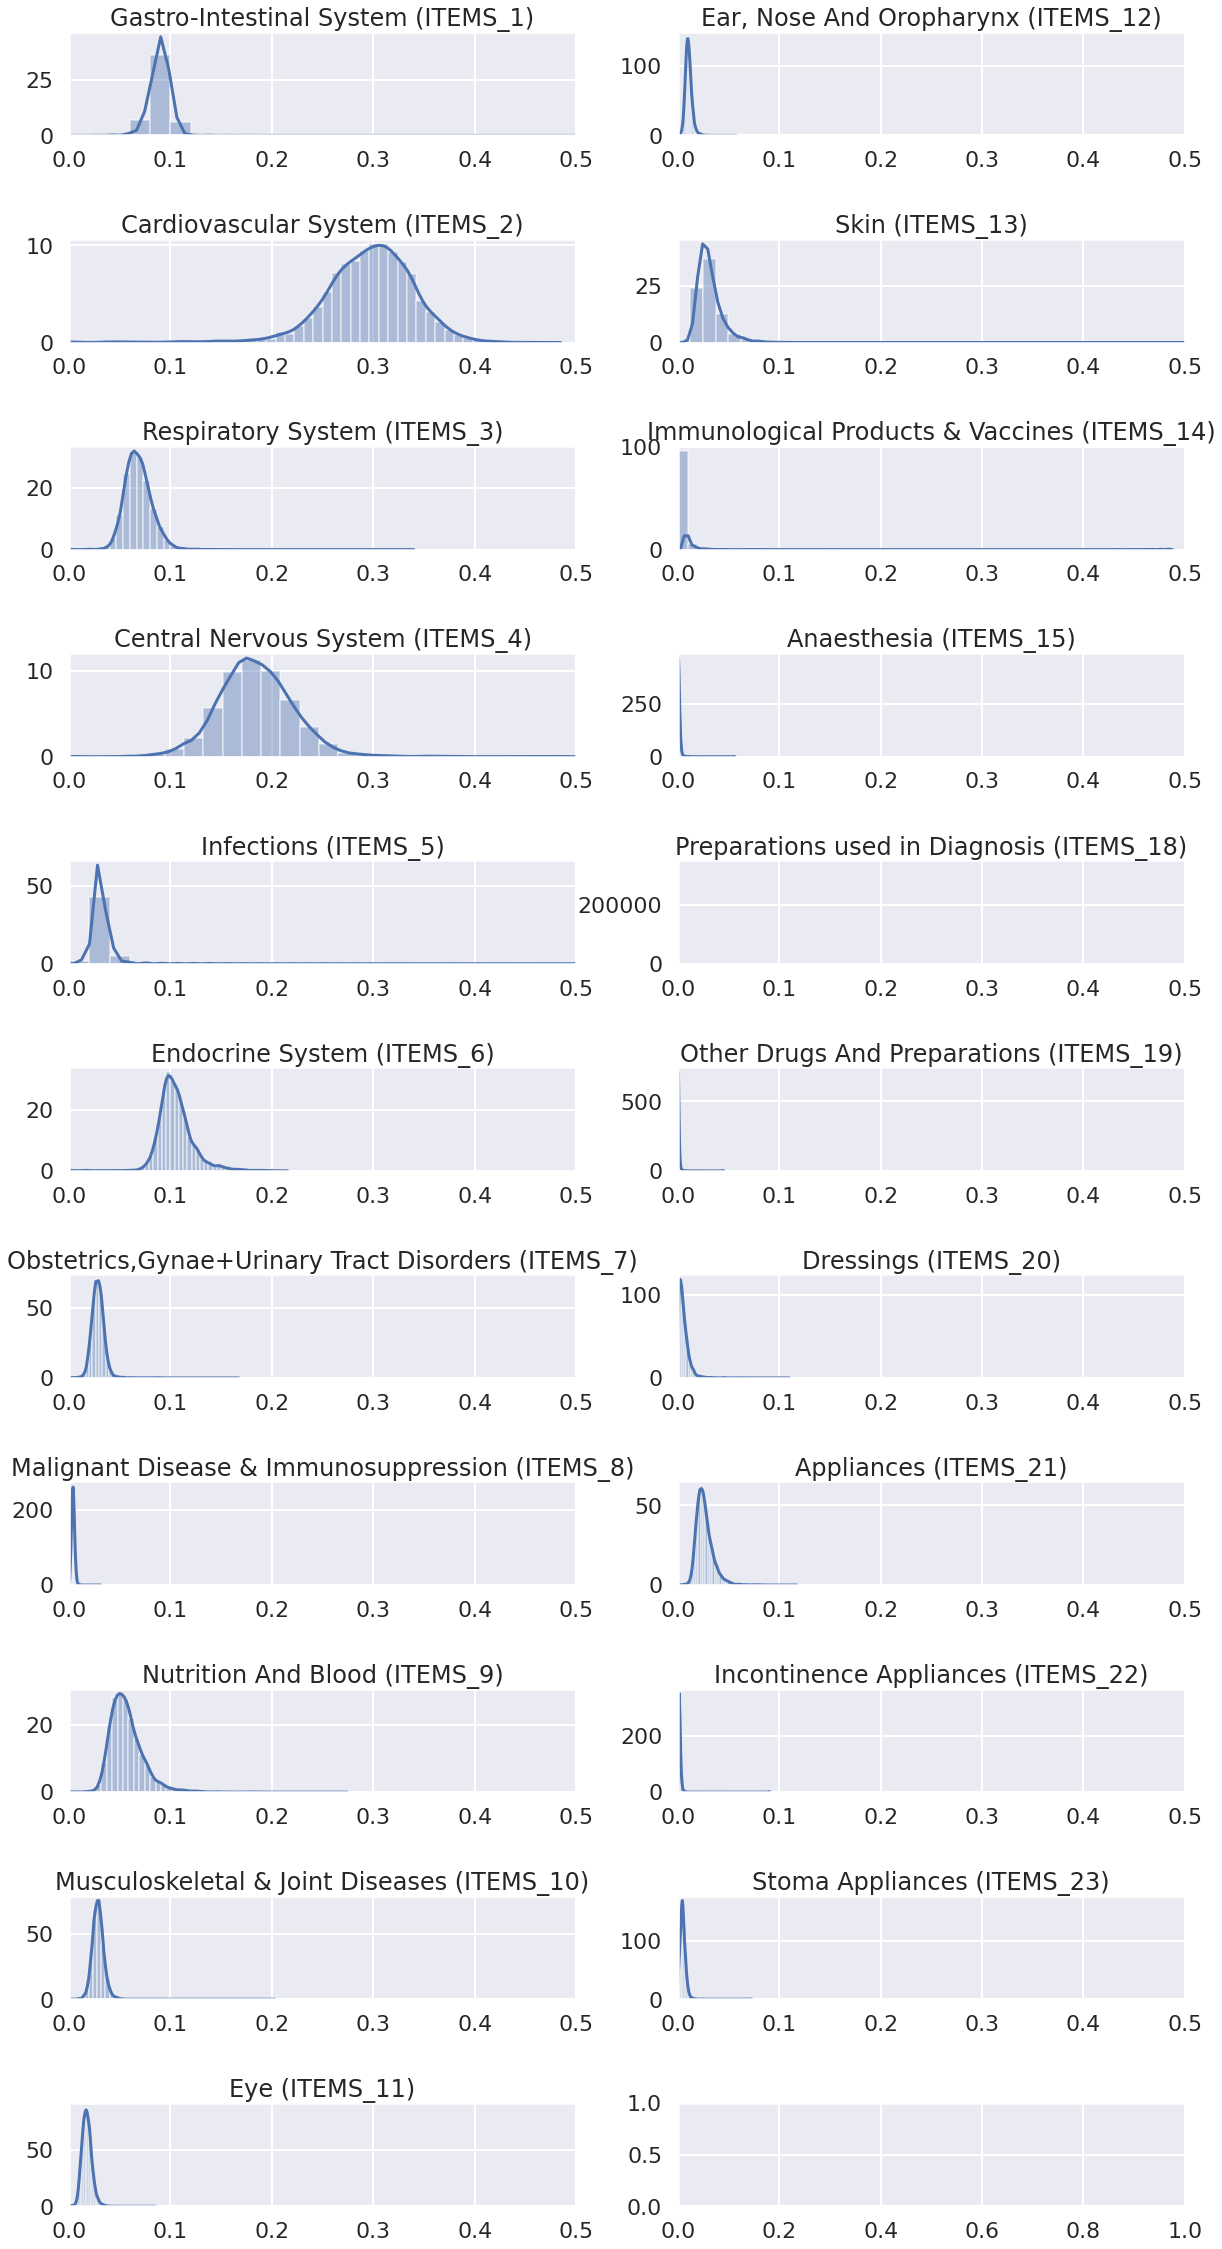

In [128]:
variables =['ITEMS_1',
       'ITEMS_2', 'ITEMS_3', 'ITEMS_4', 'ITEMS_5', 'ITEMS_6', 'ITEMS_7',
       'ITEMS_8', 'ITEMS_9', 'ITEMS_10', 'ITEMS_11', 'ITEMS_12', 'ITEMS_13',
       'ITEMS_14', 'ITEMS_15', 'ITEMS_18', 'ITEMS_19', 'ITEMS_20', 'ITEMS_21',
       'ITEMS_22', 'ITEMS_23']
n_columns = 2

n_rows = math.ceil(len(variables)/n_columns)
fig, axes = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(20,40))
plt.subplots_adjust(hspace=1)

for i in range(len(variables)):
    var = variables[i]
    title = bnf_chapter_dict[int(var.split('_')[1])] # Get ID from NIC and look it up in dict
    sns.distplot(df_chapter_drug_sales[var],
                 ax=axes[i%n_rows][i//n_rows])
    axes[i%n_rows][i//n_rows].set_xlim(0, 0.5)
    axes[i%n_rows][i//n_rows].set_title(f"{title} ({var})")
    axes[i%n_rows][i//n_rows].set_xlabel("")

## ... NIC vs. ITEMS

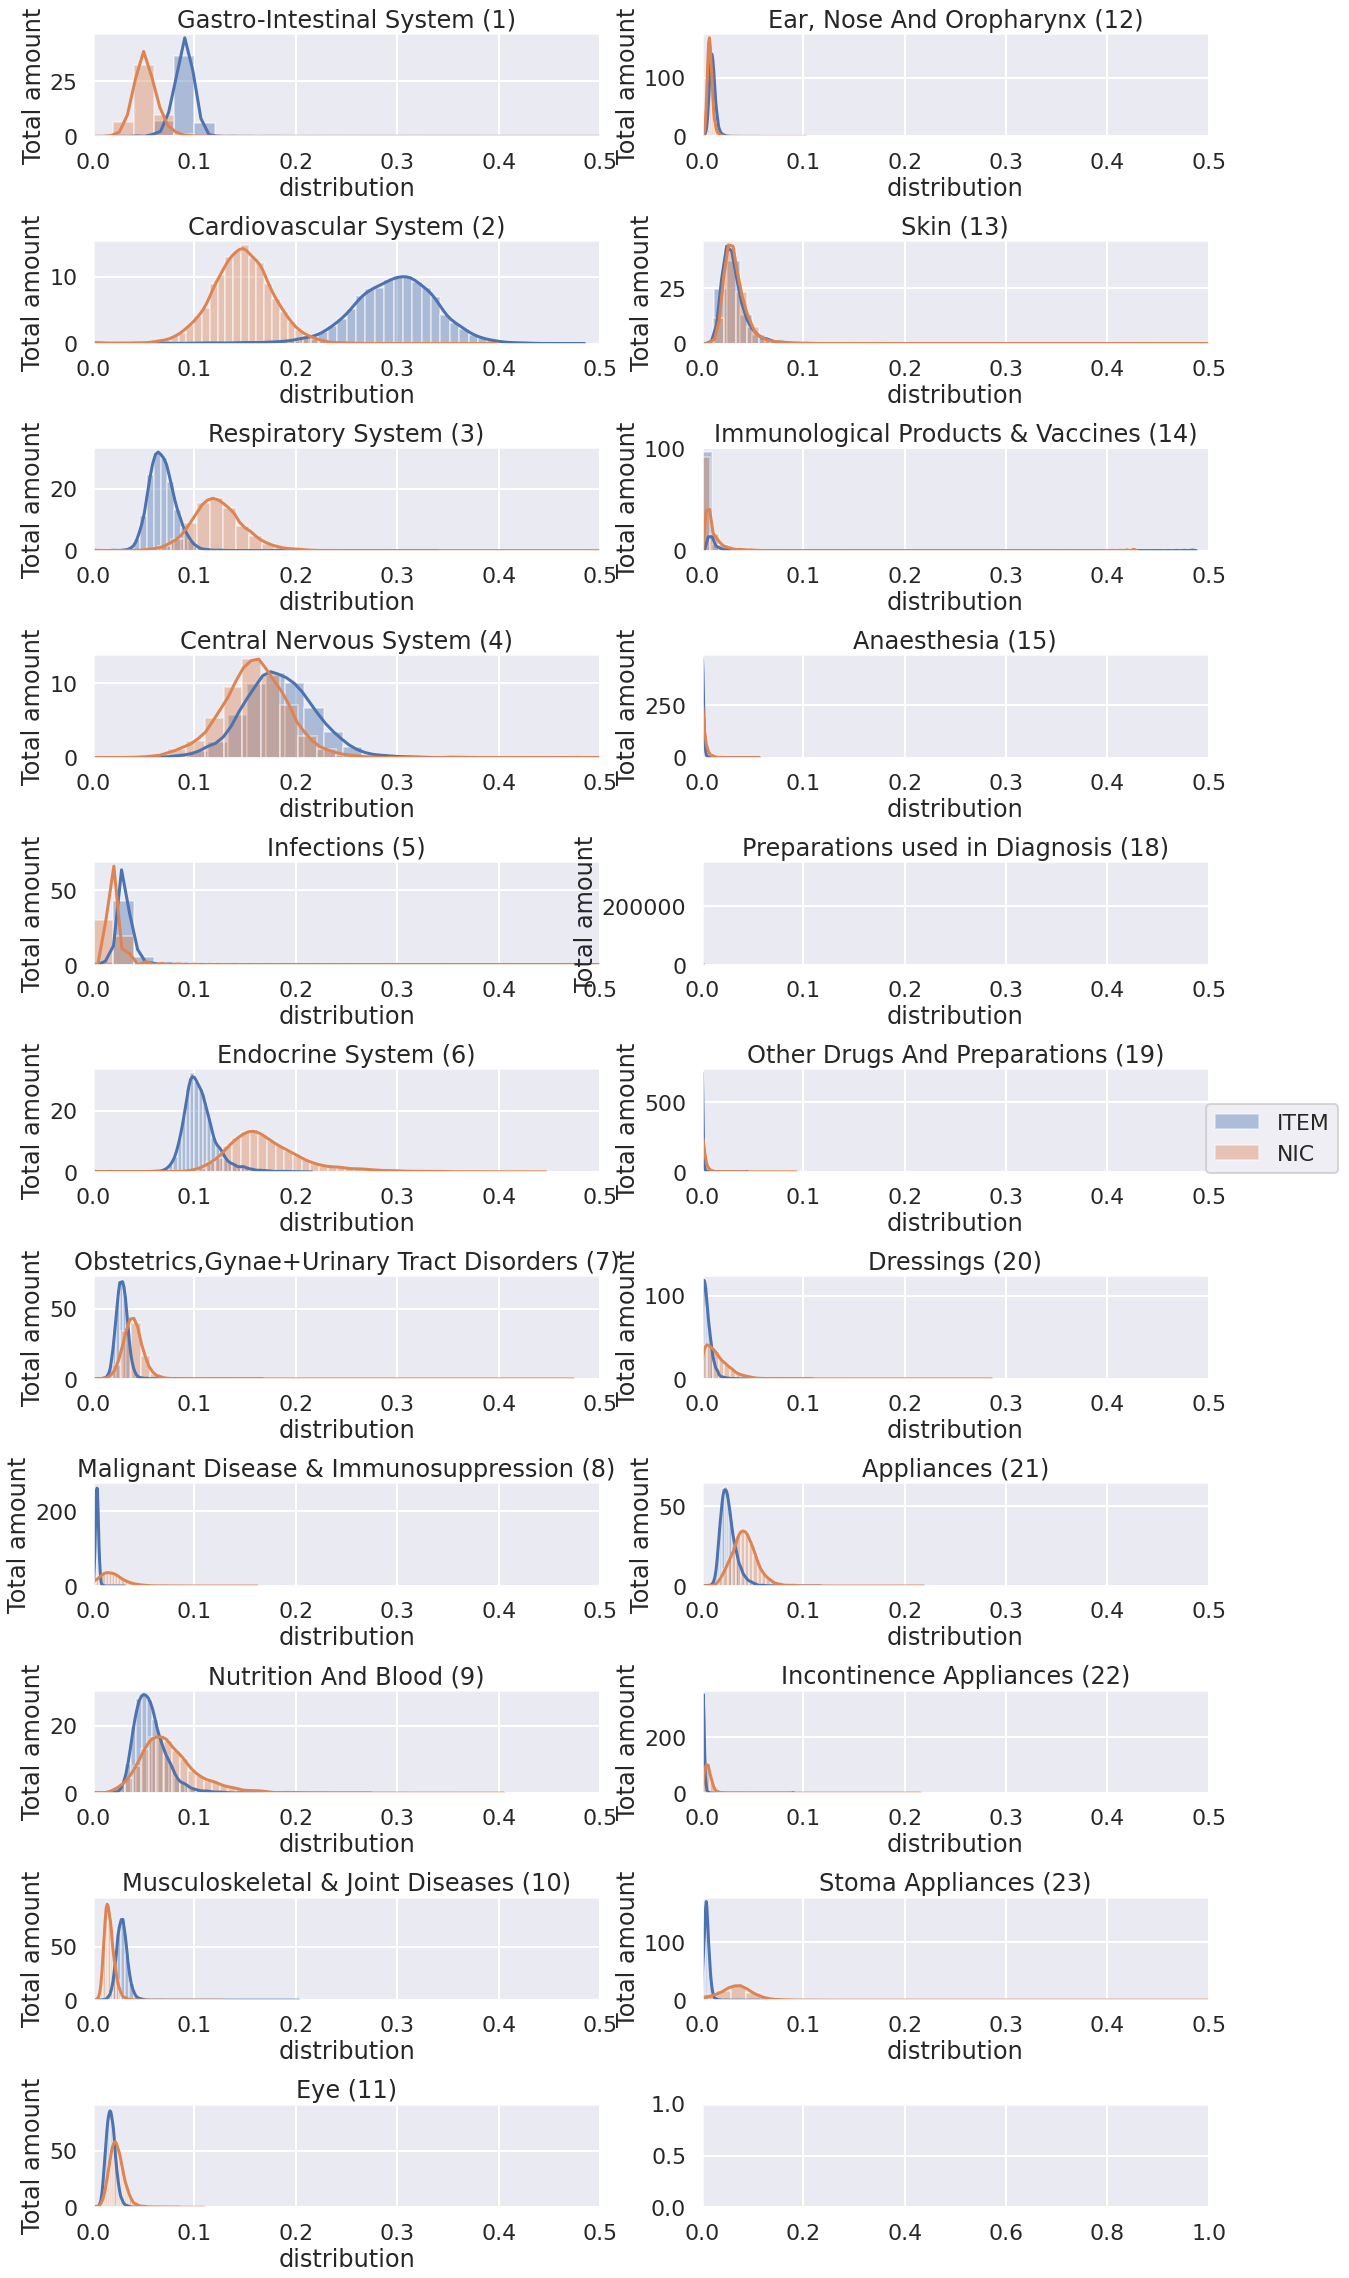

In [129]:
variables_i =['ITEMS_1',
       'ITEMS_2', 'ITEMS_3', 'ITEMS_4', 'ITEMS_5', 'ITEMS_6', 'ITEMS_7',
       'ITEMS_8', 'ITEMS_9', 'ITEMS_10', 'ITEMS_11', 'ITEMS_12', 'ITEMS_13',
       'ITEMS_14', 'ITEMS_15', 'ITEMS_18', 'ITEMS_19', 'ITEMS_20', 'ITEMS_21',
       'ITEMS_22', 'ITEMS_23']
variables_n =['NIC_1', 'NIC_2', 'NIC_3', 'NIC_4', 'NIC_5', 'NIC_6', 'NIC_7', 'NIC_8',
       'NIC_9', 'NIC_10', 'NIC_11', 'NIC_12', 'NIC_13', 'NIC_14', 'NIC_15',
       'NIC_18', 'NIC_19', 'NIC_20', 'NIC_21', 'NIC_22', 'NIC_23']

n_columns = 2

n_rows = math.ceil(len(variables)/n_columns)
fig, axes = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(20,40))
plt.subplots_adjust(hspace=1)

for i in range(len(variables_i)):
    var_i = variables_i[i]
    var_n = variables_n[i]
    chapter_id = int(var_i.split('_')[1])
    title = bnf_chapter_dict[chapter_id] # Get ID from NIC and look it up in dict
    sns.distplot(df_chapter_drug_sales[var_i],
                 label="ITEM",                 
                 ax=axes[i%n_rows][i//n_rows])
    sns.distplot(df_chapter_drug_sales[var_n],
                 label="NIC",                 
                 ax=axes[i%n_rows][i//n_rows])
        
    axes[i%n_rows][i//n_rows].set_xlim(0, 0.5)
    axes[i%n_rows][i//n_rows].set_title(f"{title} ({chapter_id})")
    axes[i%n_rows][i//n_rows].set_xlabel("distribution")
    axes[i%n_rows][i//n_rows].set_ylabel("Total amount")
fig.legend(labels=['ITEM','NIC'], loc="right")
plt.show()

## Conclusion
- Cardiovascular System (2) are the most prescribed drugs
- Some Chapters are rather Cheap:
 - Gastro-Intestinal System (1)
 - Cardiovascular System (2)
 - Musculoskeletal & Joint Diseases (10)
- Some Chapter are rather expensive:
 - Endocrine System (6)
 - Appliances (21)
 - 'Stoma Appliances (23)

### ... Sections

Too large to plot (210 Categories)

# 2. Is there a correlation between Age, Gender and Drug sales?


## Correlation Matrix

In [130]:
def corr_heatmap(df, fig_size=(12,12)):
    fig, ax = plt.subplots(figsize=fig_size)
    corr = df.corr()
    mask = np.triu(np.ones_like(df, dtype=np.bool))
    ax = sns.heatmap(df, mask=mask, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, )
    ax.set_title('Correlation matrix')
    return plt.show()

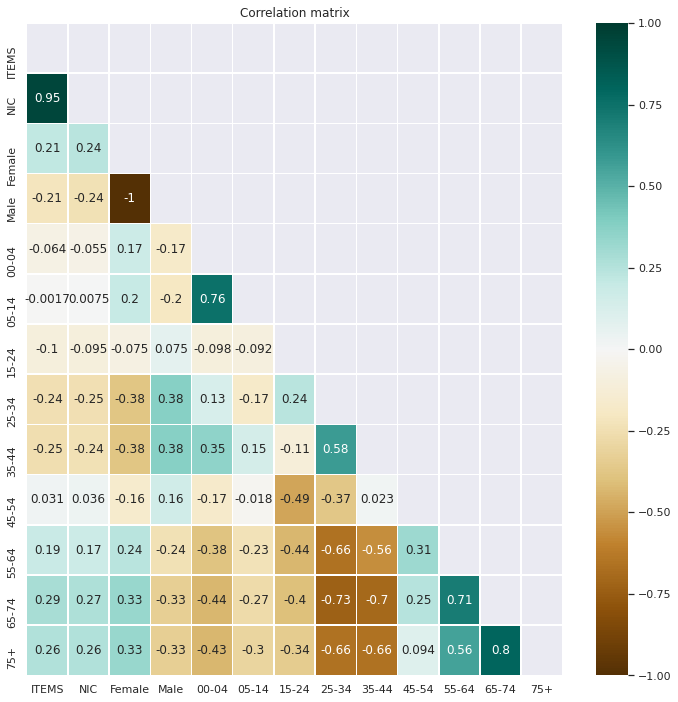

In [131]:
df_gender_and_age = df_chapter_drug_sales[["ITEMS", "NIC", "Female", "Male", '00-04', '05-14', '15-24', '25-34',
       '35-44', '45-54', '55-64', '65-74', '75+']]
sns.set("notebook")
corr_heatmap(df_gender_and_age.corr())

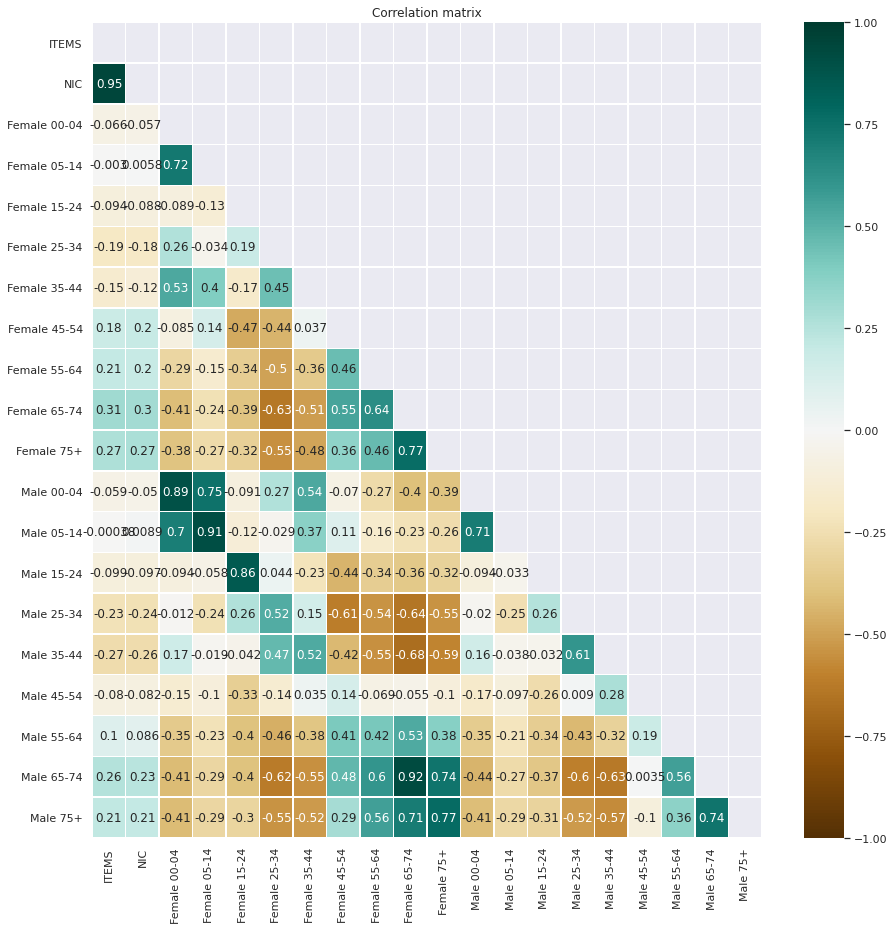

In [132]:
df_gender_and_age_group = df_chapter_drug_sales[["ITEMS", "NIC", 'Female 00-04',
       'Female 05-14', 'Female 15-24', 'Female 25-34', 'Female 35-44',
       'Female 45-54', 'Female 55-64', 'Female 65-74', 'Female 75+',
       'Male 00-04', 'Male 05-14', 'Male 15-24', 'Male 25-34', 'Male 35-44',
       'Male 45-54', 'Male 55-64', 'Male 65-74', 'Male 75+']]
sns.set("notebook")
corr_heatmap(df_gender_and_age_group.corr(), (15,15))

## Correlation Line Chart

In [133]:
df_gender_age_correlation_analysis = df_gender_and_age_group.corr()[["ITEMS", "NIC"]]
df_gender_age_correlation_analysis.drop(axis=0, labels=["ITEMS", "NIC"], inplace= True)
df_gender_age_correlation_analysis.reset_index(inplace=True)
df_gender_age_correlation_analysis["gender"] = df_gender_age_correlation_analysis["index"].apply(lambda x: re.findall(r"^[a-zA-Z]*",x)[0])
df_gender_age_correlation_analysis["age"] = df_gender_age_correlation_analysis["index"].apply(lambda x: re.findall(r"[0-9\-\+]*$",x)[0])
df_gender_age_correlation_analysis.drop(axis=1, labels=["index"], inplace= True)
df_gender_age_correlation_analysis = df_gender_age_correlation_analysis.groupby(["gender","age"]).agg("sum")
df_gender_age_correlation_analysis.reset_index(inplace=True)

In [134]:
bar = alt.Chart(df_gender_age_correlation_analysis).mark_line(point=True, strokeWidth=3).encode(
    x='age',
    y='ITEMS',
    color='gender',
    tooltip = ["age", "ITEMS", "gender"])\
.properties(title='Correlation between age and items purchased, differed by gender')

rule = alt.Chart(df_gender_age_correlation_analysis).mark_rule(color='red').encode(
    y='mean(ITEMS)'
)

(bar + rule).properties(width=800).configure_point(size=100)

alt.LayerChart(...)

In [135]:
bar = alt.Chart(df_gender_age_correlation_analysis).mark_line(point=True, strokeWidth=3).encode(
    x='age',
    y='NIC',
    color='gender',
    tooltip = ["age", "NIC", "gender"]
).properties(title='Correlation between age and nic payed, differed by gender')
rule = alt.Chart(df_gender_age_correlation_analysis).mark_rule(color='red').encode(
    y='mean(NIC)'
)

(bar + rule).properties(width=800).configure_point(size=100)

alt.LayerChart(...)

In [136]:
df_gender_and_age_group_all_items = df_chapter_drug_sales[['ITEMS_1','ITEMS_2', 'ITEMS_3', 'ITEMS_4', 'ITEMS_5', 'ITEMS_6', 'ITEMS_7',
       'ITEMS_8', 'ITEMS_9', 'ITEMS_10', 'ITEMS_11', 'ITEMS_12', 'ITEMS_13',
       'ITEMS_14', 'ITEMS_15', 'ITEMS_18', 'ITEMS_19', 'ITEMS_20', 'ITEMS_21',
       'ITEMS_22', 'ITEMS_23', 'Female 00-04',
       'Female 05-14', 'Female 15-24', 'Female 25-34', 'Female 35-44',
       'Female 45-54', 'Female 55-64', 'Female 65-74', 'Female 75+',
       'Male 00-04', 'Male 05-14', 'Male 15-24', 'Male 25-34', 'Male 35-44',
       'Male 45-54', 'Male 55-64', 'Male 65-74', 'Male 75+']]

### Correlation based on chapters

In [138]:
item_list = ['ITEMS_1','ITEMS_2', 'ITEMS_3', 'ITEMS_4', 'ITEMS_5', 'ITEMS_6', 'ITEMS_7',
       'ITEMS_8', 'ITEMS_9', 'ITEMS_10', 'ITEMS_11', 'ITEMS_12', 'ITEMS_13',
       'ITEMS_14', 'ITEMS_15', 'ITEMS_18', 'ITEMS_19', 'ITEMS_20', 'ITEMS_21',
       'ITEMS_22', 'ITEMS_23']

df_all_items_correlation_analysis = df_gender_and_age_group_all_items.corr()[item_list]
df_all_items_correlation_analysis = df_all_items_correlation_analysis.drop(item_list)
df_all_items_correlation_analysis.reset_index(inplace=True)
df_all_items_correlation_analysis["gender"] = df_all_items_correlation_analysis["index"].apply(lambda x: re.findall(r"^[a-zA-Z]*",x)[0])
df_all_items_correlation_analysis["age"] = df_all_items_correlation_analysis["index"].apply(lambda x: re.findall(r"[0-9\-\+]*$",x)[0])
df_all_items_correlation_analysis.drop(axis=1, labels=["index"], inplace= True)
df_all_items_correlation_analysis = df_all_items_correlation_analysis.groupby(["gender","age"]).agg("sum")
df_all_items_correlation_analysis.reset_index(inplace=True)

In [139]:
df_all_items_correlation_analysis['age'].values

array(['00-04', '05-14', '15-24', '25-34', '35-44', '45-54', '55-64',
       '65-74', '75+', '00-04', '05-14', '15-24', '25-34', '35-44',
       '45-54', '55-64', '65-74', '75+'], dtype=object)

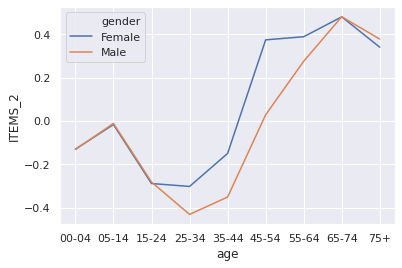

In [148]:
sns.lineplot(x='age'
                 , y= item_list[1]
                 , hue='gender'
                , data=df_all_items_correlation_analysis
                 )

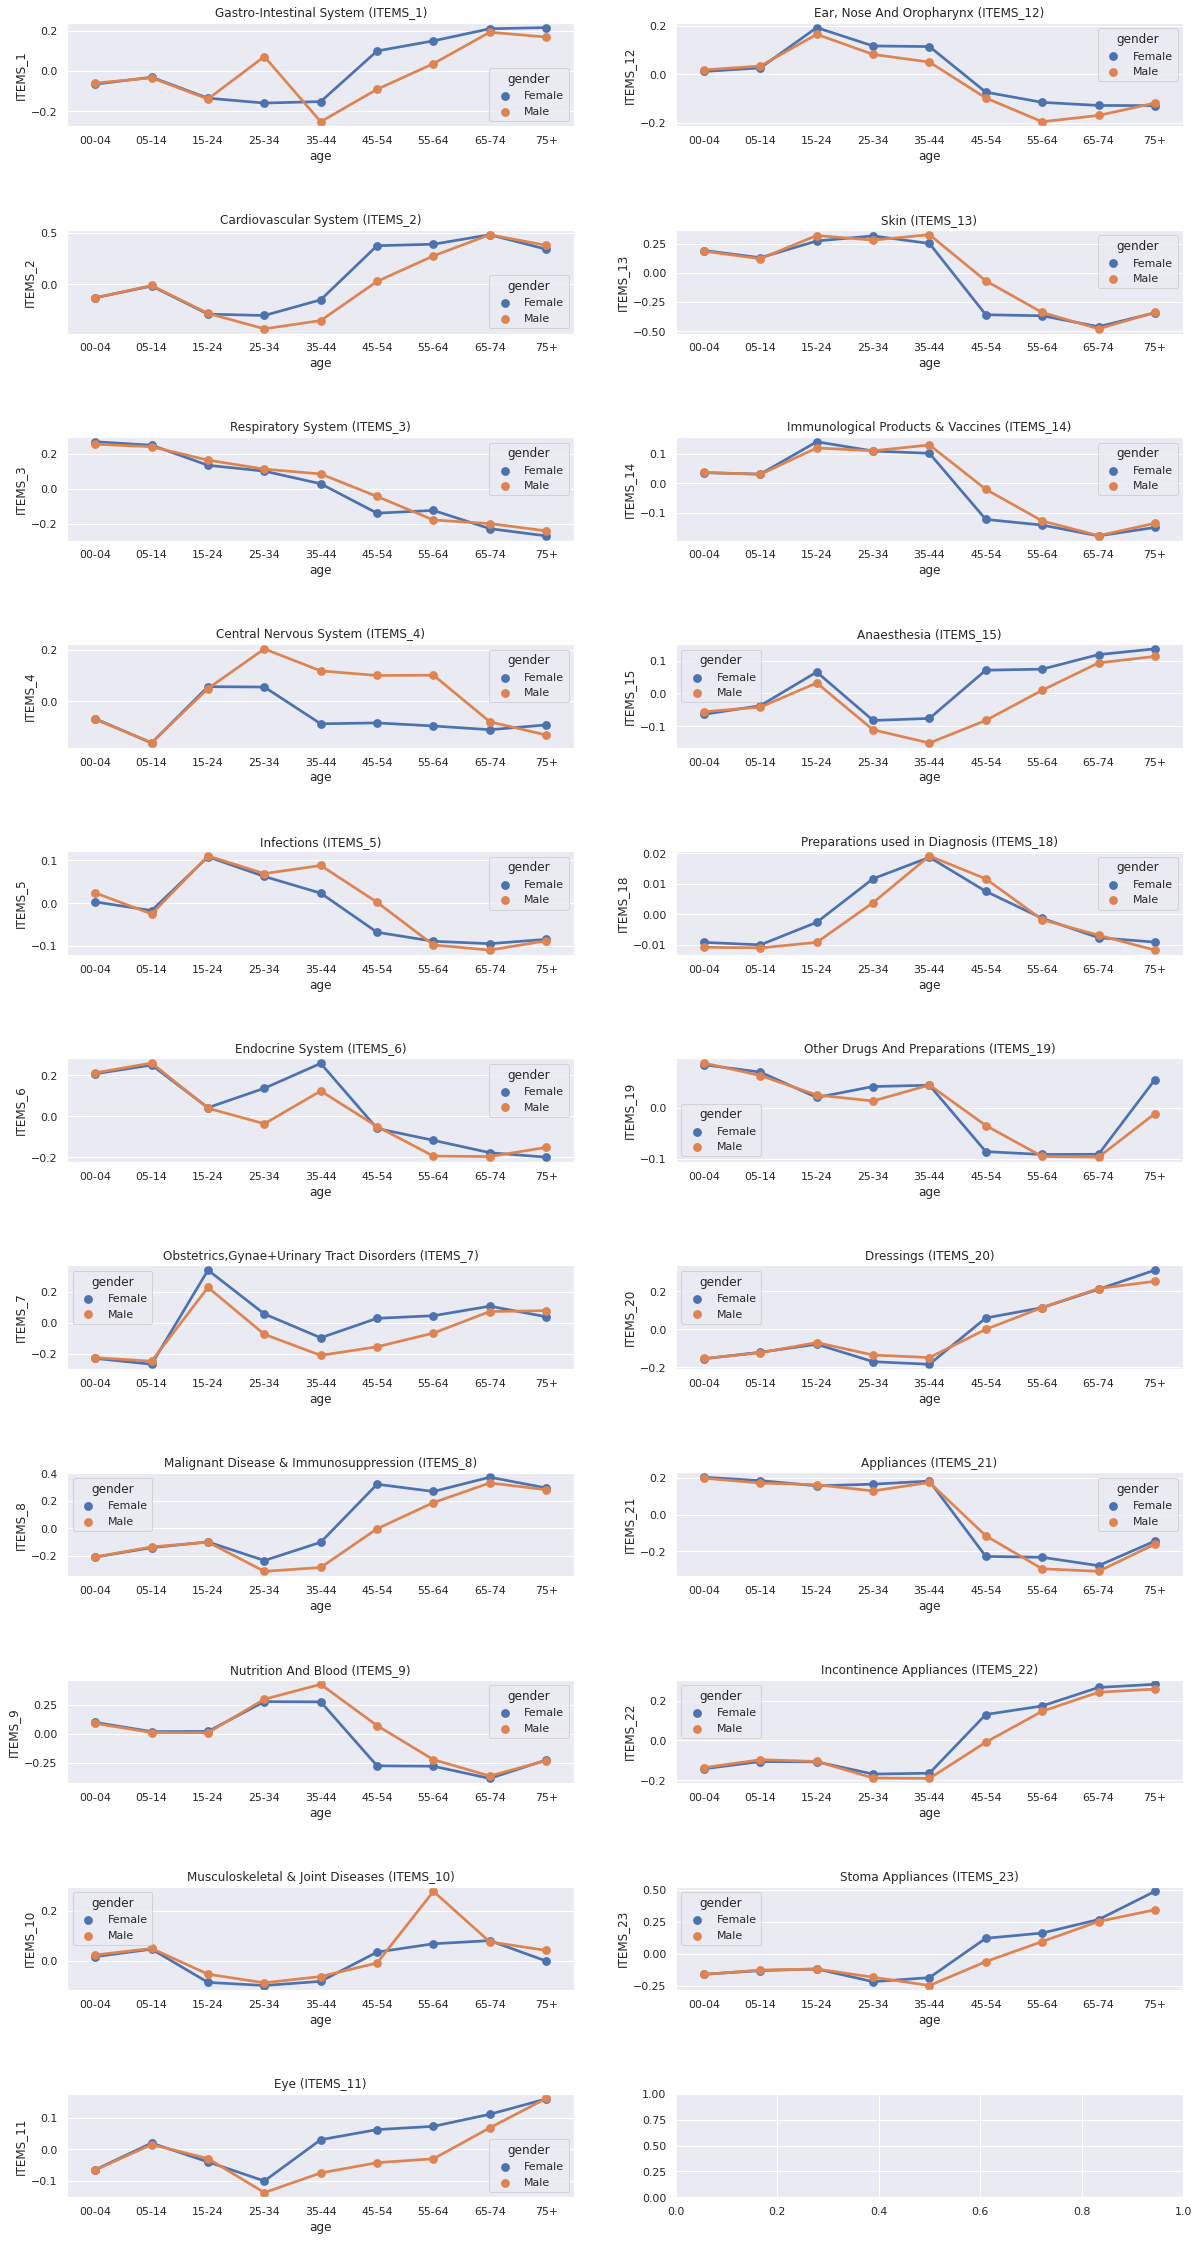

In [150]:
n_columns = 2

n_rows = math.ceil(len(item_list)/n_columns)
fig, axes = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(20,40))
plt.subplots_adjust(hspace=1)

for i in range(len(item_list)):
    var = item_list[i]
    title = bnf_chapter_dict[int(var.split('_')[1])] # Get ID from ITEM and look it up in dict
    sns.pointplot(x='age'
                 , y= var
                 , hue='gender'
                 , ax=axes[i%n_rows][i//n_rows]
                 , data=df_all_items_correlation_analysis
                 )
    axes[i%n_rows][i//n_rows]
    axes[i%n_rows][i//n_rows].set_title(f"{title} ({var})")
    axes[i%n_rows][i//n_rows].set_xlabel("age")

## Conclusions:
- Overall, there is a strong correlation between gender, but within age groups they differ extremly 
 - 35-44: 0.14 
 - 65-74: 0.92
- Males between 35 and 44 consume the lowest amount of drugs (-0.27)
- Female between 65 and 74 consume the highest amount of drugs (+0.31)
- At younger age, gender shows no difference in correlation between sexes, 
this changes at the age of 25 and has its peak between 45 and 54.
- There is a low, but existing, difference between amount of Items and it's Costs (NIC)


### To Do:
- Statt alle NICs & ITEMs -> vergleiche einzelne Chapters mit Alter / Geschlecht

# 3. How can GP be clustered?

## Prepare Data

In [ ]:
# Normalize ITEM and NIC totals and drop the absolute values
max_items = max(df_chapter_drug_sales["ITEMS"])
max_nics = max(df_chapter_drug_sales["NIC"])
df_chapter_normalized = df_chapter_drug_sales.copy()
df_chapter_normalized["ITEMS_N"] = df_chapter_normalized["ITEMS"].apply(lambda x : x / max_items)
df_chapter_normalized["NIC_N"] = df_chapter_normalized["NIC"].apply(lambda x : x / max_nics)
df_chapter_normalized.drop(axis=1, labels=["ITEMS", "NIC"], inplace=True)
df_chapter_normalized

,PRACTICE,Female,Male,00-04,05-14,15-24,25-34,35-44,45-54,55-64,65-74,75+,Female 00-04,Female 05-14,Female 15-24,Female 25-34,Female 35-44,Female 45-54,Female 55-64,Female 65-74,Female 75+,Male 00-04,Male 05-14,Male 15-24,Male 25-34,Male 35-44,Male 45-54,Male 55-64,Male 65-74,Male 75+,NIC_1,NIC_2,NIC_3,NIC_4,NIC_5,NIC_6,NIC_7,NIC_8,NIC_9,NIC_10,NIC_11,NIC_12,NIC_13,NIC_14,NIC_15,NIC_18,NIC_19,NIC_20,NIC_21,NIC_22,NIC_23,ITEMS_1,ITEMS_2,ITEMS_3,ITEMS_4,ITEMS_5,ITEMS_6,ITEMS_7,ITEMS_8,ITEMS_9,ITEMS_10,ITEMS_11,ITEMS_12,ITEMS_13,ITEMS_14,ITEMS_15,ITEMS_18,ITEMS_19,ITEMS_20,ITEMS_21,ITEMS_22,ITEMS_23,ITEMS_N,NIC_N
0,A81001,0.506673,0.493327,0.049988,0.120844,0.104829,0.125212,0.117205,0.124970,0.123999,0.114778,0.118175,0.024509,0.062606,0.053870,0.063334,0.052657,0.061636,0.063819,0.057753,0.066489,0.025479,0.058238,0.050959,0.061878,0.064547,0.063334,0.060180,0.057025,0.051686,0.056223,0.157726,0.142735,0.167511,0.016819,0.156060,0.037295,0.017994,0.074164,0.011891,0.027607,0.007233,0.037510,0.009665,0.007483,0.0,0.001373,0.015130,0.031614,0.004434,0.019533,0.086321,0.249219,0.073204,0.247345,0.030106,0.096190,0.020862,0.004997,0.061212,0.022986,0.019738,0.008245,0.041099,0.004747,0.000750,0.0,0.001124,0.007995,0.018863,0.001374,0.003623,0.073148,0.064188
1,A81002,0.507403,0.492597,0.047379,0.109668,0.099226,0.133306,0.106291,0.133254,0.152475,0.115902,0.102499,0.025144,0.054860,0.047795,0.066237,0.051327,0.066185,0.075952,0.059847,0.060055,0.022235,0.054808,0.051431,0.067068,0.054964,0.067068,0.076523,0.056055,0.042444,0.061945,0.145536,0.161891,0.157818,0.018375,0.149729,0.034502,0.021213,0.077802,0.014817,0.022739,0.006790,0.033317,0.004202,0.003055,0.0,0.001670,0.012934,0.037903,0.003074,0.030689,0.094262,0.293181,0.078331,0.209160,0.027412,0.089865,0.024542,0.003491,0.062686,0.029300,0.017818,0.008715,0.027878,0.002198,0.000905,0.0,0.000905,0.005120,0.018490,0.001060,0.004681,0.353351,0.320746
2,A81004,0.483163,0.516837,0.057153,0.111394,0.109756,0.160903,0.124135,0.123771,0.121223,0.100746,0.090917,0.027120,0.055060,0.051875,0.072716,0.057153,0.057608,0.057790,0.052330,0.051511,0.030033,0.056334,0.057881,0.088187,0.066982,0.066163,0.063433,0.048416,0.039407,0.060667,0.143918,0.110334,0.169418,0.031567,0.148483,0.042506,0.013335,0.077945,0.012791,0.020668,0.006895,0.040052,0.000800,0.003071,0.0,0.001653,0.028635,0.043309,0.003559,0.040393,0.086421,0.288862,0.065302,0.211678,0.032192,0.108945,0.027115,0.004267,0.040834,0.029977,0.018797,0.010263,0.036621,0.000486,0.000756,0.0,0.001188,0.007994,0.021659,0.001188,0.005455,0.169178,0.172332
3,A81005,0.515166,0.484834,0.041631,0.108437,0.080560,0.098244,0.112980,0.132506,0.133120,0.160629,0.131892,0.020877,0.054280,0.040280,0.048876,0.057350,0.066437,0.069999,0.085841,0.071227,0.020754,0.054157,0.040280,0.049368,0.055631,0.066069,0.063122,0.074788,0.060666,0.073851,0.163154,0.134273,0.135219,0.016623,0.130996,0.047607,0.025108,0.055085,0.010108,0.021823,0.008470,0.035835,0.003579,0.003217,0.0,0.001429,0.017893,0.064823,0.006161,0.044748,0.098744,0.345634,0.062744,0.161849,0.023619,0.108961,0.033415,0.005770,0.042551,0.025242,0.018571,0.011659,0.025422,0.001683,0.000901,0.0,0.000841,0.003846,0.021275,0.001683,0.005589,0.152045,0.122095
4,A81006,0.503553,0.496447,0.055695,0.126751,0.108344,0.139338,0.121540,0.128375,0.139135,0.104690,0.076132,0.026257,0.061108,0.053055,0.069500,0.060702,0.062665,0.070312,0.054544,0.045408,0.029438,0.065643,0.055289,0.069838,0.060838,0.065710,0.068823,0.050145,0.030723,0.058561,0.134753,0.184717,0.153028,0.022751,0.139594,0.035716,0.031853,0.071647,0.015066,0.019302,0.007284,0.034108,0.001410,0.005415,0.0,0.003071,0.020939,0.040715,0.002512,0.017556,0.094323,0.309311,0.088266,0.204500,0.026653,0.096435,0.022015,0.003565,0.042575,0.027449,0.013776,0.008169,0.028072,0.000658,0.001142,0.0,0.000935,0.007269,0.020249,0.000865,0.003773,0.263992,0.224075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
features = ['Female 00-04','Female 05-14', 'Female 15-24', 'Female 25-34', 'Female 35-44',
       'Female 45-54', 'Female 55-64', 'Female 65-74', 'Female 75+',
       'Male 00-04', 'Male 05-14', 'Male 15-24', 'Male 25-34', 'Male 35-44',
       'Male 45-54', 'Male 55-64', 'Male 65-74', 'Male 75+', 'NIC_1', 'NIC_2',
       'NIC_3', 'NIC_4', 'NIC_5', 'NIC_6', 'NIC_7', 'NIC_8', 'NIC_9', 'NIC_10',
       'NIC_11', 'NIC_12', 'NIC_13', 'NIC_14', 'NIC_15', 'NIC_18', 'NIC_19',
       'NIC_20', 'NIC_21', 'NIC_22', 'NIC_23', 'ITEMS_1', 'ITEMS_2', 'ITEMS_3',
       'ITEMS_4', 'ITEMS_5', 'ITEMS_6', 'ITEMS_7', 'ITEMS_8', 'ITEMS_9',
       'ITEMS_10', 'ITEMS_11', 'ITEMS_12', 'ITEMS_13', 'ITEMS_14', 'ITEMS_15',
       'ITEMS_18', 'ITEMS_19', 'ITEMS_20', 'ITEMS_21', 'ITEMS_22', 'ITEMS_23',
       'ITEMS_N', 'NIC_N']

## PCA

### Modell

In [ ]:
# Create DF with relevant Features
x = df_chapter_normalized.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Make PCA
pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(x)

In [ ]:
pca_variance = pca.explained_variance_ratio_
running_sum=0
pca_summed = []

for var in pca_variance:
  running_sum += var
  pca_summed.append(running_sum)

df_pca_variance = pd.DataFrame({"pca": list(range(1,len(features)+1)),
                                "variance": pca_variance,
                                "variance_summed": pca_summed                               
                                })

### Analyze Output

In [ ]:
alt.Chart(df_pca_variance,
    width=900,
    height=400
    ).mark_bar().encode(
    x='pca',
    y='variance',
    tooltip=["pca", "variance", "variance_summed"]
).properties(title="Variance of each PCA")

alt.Chart(...)

In [ ]:
alt.Chart(df_pca_variance,
    width=900,
    height=400
    ).mark_bar().encode(
    x='pca',
    y='variance_summed',
    tooltip=["pca", "variance", "variance_summed"]
).properties(title="Summed Variance of each PCA")

alt.Chart(...)

In [ ]:
# Probably the most important features (highest variance)
principalDf = pd.DataFrame(data = principalComponents, columns = features)
principalDf.iloc[0].sort_values()

Male 35-44     -1.218338
NIC_9          -1.212892
NIC_4          -1.103714
Female 55-64   -0.900486
NIC_22         -0.772675
                  ...   
Female 75+      0.910912
Female 05-14    0.988188
NIC_7           1.099599
NIC_5           1.150096
Male 75+        1.172472
Name: 0, Length: 62, dtype: float64

### Conclusion
- The most important Features, based on PCA 1 are:
 - Male 35-44 (-1.218338)
 - NIC_9 (-1.212892)
 - Male 75+ (1.172472)
 - NIC_5 (1.150096)
 - NIC_4 (-1.103714)
- PCA 1 explains 17% of the variance
- PCA 1-8 explain >50% of all variance
- PCA 1-40 explain >95% of all variance
- Overall, PCA shows that many features are important

## Agglomerative Clustering and Chapters

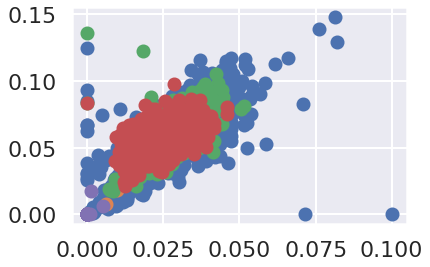

In [ ]:
# agglomerative clustering

# define dataset
X = df_chapter_normalized.loc[:, features].values
# define the model
model = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

In [ ]:
df_chapter_normalized["cluster_agglomerative"] = yhat

## Gaussian Mixture Model

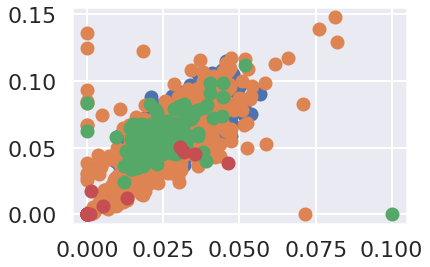

In [ ]:
# define dataset
X = df_chapter_normalized.loc[:, features].values
# define the model
model = GaussianMixture(n_components=4)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

In [ ]:
df_chapter_normalized["cluster_gaussian"] = yhat

### Export Data

In [ ]:
df_chapter_normalized[["PRACTICE","cluster_gaussian", "cluster_agglomerative"]].to_csv("./practice_and_clusters.csv")

To Do:
- Finde Methode um Anzahl Gruppen zu definieren, nicht visuelle Entscheidung
- Versuche mehrere Cluster Methoden
- Visualisiere Daten auf Karte (gibt es regionale Gruppen?)